# Data Preparation & Exploration 

In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%pylab inline
from datetime import datetime
import pickle 
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss,make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
import shap
import json

pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
TODO = 5000
train = pd.read_pickle("train_set.pickle").sample(n=TODO)
train.loc[:,"clicked"] = train.loc[:,"clicked"].map({True:1, False:0})
CALC_PARAMS = False


In [4]:
configs = pd.read_csv("configuration_01_14_2022__19_05.csv").set_index('index')
configs

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
index,,,,,,,
RF,0.926,0.026316,1.000000,0.778993,-2.555869,0.766859,"{""class_weight"": ""balanced"", ""criterion"": ""gin..."
knn,0.926,0.026316,1.000000,0.760253,-2.555869,0.280000,"{""leaf_size"": 30, ""n_neighbors"": 100, ""weights..."
catboost,0.922,0.026316,0.333333,0.780360,-2.694028,0.173593,"{""min_data_in_leaf"": 100, ""depth"": 4, ""l2_leaf..."


In [5]:
def get_config(model):
    d = configs.loc[model].params
    params = json.loads(d)
    print (params)
    return (params)

In [6]:
def add_features(df):

    df.loc[:,'time'] = pd.to_datetime(df['timestamp'], unit='s')
    df.loc[:,'Day_of_Week'] = df['time'].dt.weekday_name
    # note monday == 0 
    df.loc[:,'weekend'] = df['time'].dt.dayofweek > 4

    df.loc[:,'Month'] = df['time'].dt.month_name().str[:3]
    df.loc[:,'hour'] = df['time'].dt.hour

    df.loc[:,'device_diag'] = np.sqrt(df.device_height^2 + df.device_width^2).round()
    df.loc[:,'manufacturer'] = df['manufacturer'].fillna('Unknown')
    return df

In [7]:
train = add_features(train)

# splitting the data test to 4 parts:
1. training: 80%
2. validation: 10% - for param running 
3. test set: 10% a final test set to evaluate the perfromance of the final model, only after all tunning has completed.

In [8]:
train_df, other = train_test_split(train, test_size=0.2, random_state=42)
dev_val, dev_test = train_test_split(other, test_size=0.5, random_state=42)


In [9]:
train_df.shape, dev_val.shape,  dev_test.shape

((4000, 18), (500, 18), (500, 18))

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 315054 to 819513
Data columns (total 18 columns):
timestamp         4000 non-null int64
state             4000 non-null object
user_isp          3999 non-null object
app_id            4000 non-null object
app_cat           4000 non-null object
banner_pos        4000 non-null object
manufacturer      4000 non-null object
device_model      2810 non-null object
device_version    4000 non-null object
device_height     4000 non-null int64
device_width      4000 non-null int64
clicked           4000 non-null int64
time              4000 non-null datetime64[ns]
Day_of_Week       4000 non-null object
weekend           4000 non-null bool
Month             4000 non-null object
hour              4000 non-null int64
device_diag       4000 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 566.4+ KB


In [11]:
# TODO update features list
features = ['app_cat', 'banner_pos', 'device_diag', 'state' , 'Day_of_Week', 'Month', 'hour' , 'device_version' , 'manufacturer']
cat_features = ['app_cat','banner_pos','state' ,  'Day_of_Week', 'Month', 'hour','device_version' , 'manufacturer']

In [12]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']


# exploring the Target Encoder

Target encoding is a novel and usefull method for converting high-cardinality categorical variable to a continuous value
for classification taks
by encoding for each level the propoprion of rows in which Y =1
i.e. for click prediction task it encodes the ctr for each level

In [13]:
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(X_train, y_train)


TargetEncoder(cols=['app_cat', 'banner_pos', 'state', 'Day_of_Week', 'Month',
                    'hour', 'device_version', 'manufacturer'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0, verbose=0)

In [14]:
X_val_encoded = encoder.fit_transform(X_val, y_val)

In [15]:
X_val_encoded.describe()

,app_cat,banner_pos,device_diag,state,Day_of_Week,Month,hour,device_version,manufacturer
count,5.000000e+02,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000
mean,6.248401e-02,0.062000,40.840000,6.216536e-02,0.062000,0.061929,0.062011,0.061929,0.062762
std,6.417629e-02,0.081167,10.010536,6.472183e-02,0.030312,0.034810,0.049286,0.027914,0.028623
min,1.896594e-08,0.000000,22.000000,1.277915e-10,0.025974,0.036232,0.000000,0.000008,0.000021
25%,3.703704e-02,0.000000,31.000000,2.940404e-03,0.026667,0.036232,0.000153,0.044118,0.044643
50%,4.032258e-02,0.000000,45.000000,5.263158e-02,0.070175,0.046392,0.062500,0.065934,0.057851
75%,6.976744e-02,0.086207,45.000000,1.034483e-01,0.080645,0.081301,0.105263,0.066667,0.071895
max,4.792275e-01,0.237288,64.000000,3.822037e-01,0.107143,0.241084,0.166665,0.241084,0.300990


In [16]:
X_val_encoded.drop_duplicates()

,app_cat,banner_pos,device_diag,state,Day_of_Week,Month,hour,device_version,manufacturer
1646527,6.976744e-02,0.000000,45.0,6.666667e-02,0.107143,0.046392,1.481481e-01,0.065934,0.044643
622129,1.851852e-02,0.067797,45.0,4.149568e-04,0.080645,0.081301,1.729471e-11,0.065934,0.071895
1894608,4.032258e-02,0.000000,26.0,1.034483e-01,0.079545,0.036232,1.729471e-11,0.044118,0.103448
579966,4.032258e-02,0.000000,45.0,6.451613e-02,0.035088,0.036232,1.052632e-01,0.038835,0.088889
1294885,4.032258e-02,0.086207,45.0,1.176471e-01,0.079545,0.046392,1.111111e-01,0.065934,0.057851
1275785,4.347826e-02,0.000000,31.0,9.999531e-02,0.107143,0.046392,6.250000e-02,0.038835,0.071895
1141201,6.200000e-02,0.000000,45.0,1.538462e-02,0.035088,0.036232,4.701188e-11,0.065934,0.044643
1573042,3.030303e-02,0.000000,63.0,2.079171e-05,0.107143,0.036232,1.729471e-11,0.065934,0.057851
866452,3.030303e-02,0.067797,45.0,6.666667e-02,0.026667,0.046392,1.111111e-01,0.065934,0.044643
1547183,4.032258e-02,0.000000,49.0,1.034483e-01,0.035088,0.036232,0.000000e+00,0.038835,0.057851


# Preparing for pipeline creation

In [17]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [18]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [19]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [20]:
-log_loss([0],y_pred=[1], labels=[0,1])

-34.53957599234088

In [21]:
def find_threshold_by_logloss(y, y_hat, plot=False):
    return (-log_loss(y,y_hat), None)


In [22]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_metric = 0
    worst_metric = 1
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g)
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        curr_metric, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best metric", best_metric, ", Grid:", best_grid)
    print ("worst metric", worst_metric, ", Grid:", best_grid)
    return best_grid

In [23]:
def evaulate_pipeline(pipe, X, y, params):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
   
    result = {
        "Accuracy": accuracy_score(y, y_pred, normalize=True),
        "Recall": recall_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "AUC": auc,
        "-LogLoss(higer is better)": -log_loss(y, y_pred),
        "threshold":   best_threshold,
        "params": json.dumps(params)
    }
    return result
    

# Model 1: Random Forest PipeLine

In [24]:
def make_rf_pipe_line(calibration = None, params = None ):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features)
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


### Parameters being tuned:
1. min_samples_leaf = the minimal number of observations in a new leaf that are required in order for creating it
2. max_depth        = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. class_weight     = the strategy for creating class weights to handle imbalanced data
4. n_estimators     = the totl number of trees in the forest
5. criterion        = the metric for calculating improvement in information by the node splitting: Gini inequality or entropy

In [25]:
# this is a long step, was executed and saved previously

if CALC_PARAMS:


    rf_params_grid ={'min_samples_leaf': [100], 
                     'max_depth': [4] ,
                     'class_weight' : ['balanced'],
                     'n_estimators': [100],
                     'criterion': ["gini"]

                    }
    best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)
else:
    get_config
    best_rf_params = get_config('RF')


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 100, 'n_estimators': 100}


In [26]:

rf_pipe = make_rf_pipe_line(calibration = None, params = best_rf_params)


Best Threshold: 0.7616342461065742 , with accuracy =  0.938


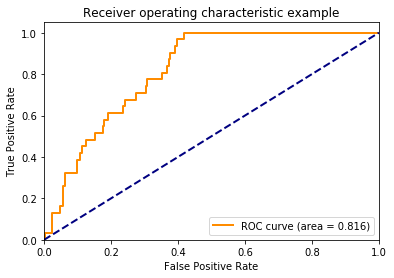

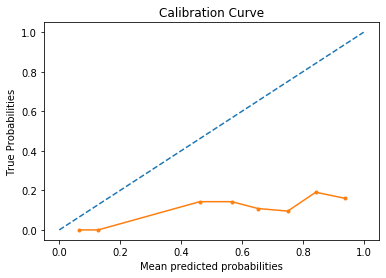

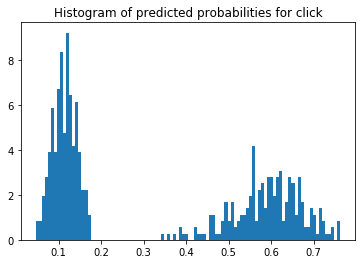

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.938,0.032258,0.5,0.816425,-2.141406,0.761634,"{""class_weight"": ""balanced"", ""criterion"": ""gin..."


In [27]:
rf_results = evaulate_pipeline(rf_pipe, X_val, y_val,best_rf_params)
rf_df = pd.DataFrame(rf_results, index= ['RF'])
rf_df

# Model 2: CatBoost 

In [28]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)


In [29]:
def make_catboost_pipe_line(train_pool, validation_pool , class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=validation_pool, plot=True)
    return model


### Parameters being tuned:
1. min_child_samples  = the minimal number of observations in a new leaf that are required in order for creating it
2. depth              = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. l2_leaf_reg        = L2 regularization coeffecient  
4. n_estimators       = the totl number of trees in the forest
5. subsample          = proprtion of rows sampled in each tree growin


In [30]:
catboost_params_grid ={ 
                  'depth': [4,6,8] ,
                  'min_child_samples' : [100,500,1000],
                  'n_estimators': [100,200],
                  'subsample': [0.75,0.95],
                  'l2_leaf_reg':[1,2],
                       
                }
#find_best_params_catboost(catboost_params_grid, train_pool, es_pool, X_val, y_val)

In [31]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
if CALC_PARAMS:

    search_results = model.randomized_search(catboost_params_grid,
                      train_pool,
                      y=None,
                      cv=3,
                      n_iter=10,
                      partition_random_seed=0,
                      calc_cv_statistics=True,
                      search_by_train_test_split=True,
                      refit=True,
                      shuffle=True,
                      stratified=None,
                      train_size=0.8,
                      verbose=False,
                      log_cout=sys.stdout,
                  log_cerr=sys.stderr)

    best_catboost_params = search_results['params']
    best_catboost_params

else:
    best_catboost_params = get_config('catboost')

{'min_data_in_leaf': 100, 'depth': 4, 'l2_leaf_reg': 1, 'iterations': 200, 'subsample': 0.75}


### optimized configuration for catboost

### Train a final cat boost model with the optimized params

In [32]:
catboost_pipe = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, params = best_catboost_params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6599043	test: 0.6594639	best: 0.6594639 (0)	total: 57.9ms	remaining: 11.5s
30:	learn: 0.2447116	test: 0.2345080	best: 0.2345080 (30)	total: 321ms	remaining: 1.75s
60:	learn: 0.2054621	test: 0.1935676	best: 0.1935676 (60)	total: 669ms	remaining: 1.52s
90:	learn: 0.1952120	test: 0.1856978	best: 0.1856978 (90)	total: 1.12s	remaining: 1.34s
120:	learn: 0.1911057	test: 0.1832896	best: 0.1832896 (120)	total: 1.46s	remaining: 950ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1830801335
bestIteration = 126

Shrink model to first 127 iterations.


Best Threshold: 0.2405322875911637 , with accuracy =  0.938


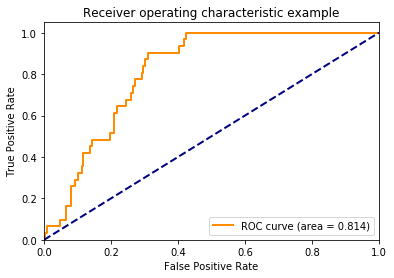

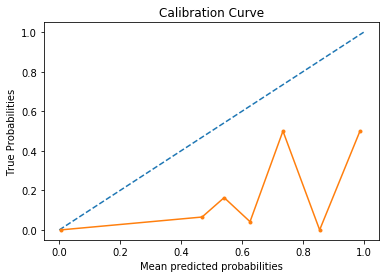

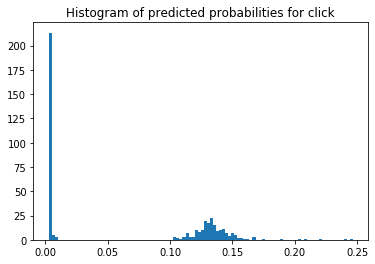

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
catboost,0.938,0.032258,0.5,0.813536,-2.141406,0.240532,"{""min_data_in_leaf"": 100, ""depth"": 4, ""l2_leaf..."


In [33]:
catboost_results = evaulate_pipeline(catboost_pipe, X_val, y_val, best_catboost_params)
catboost_df = pd.DataFrame(catboost_results, index= ['catboost'])
catboost_df

# Model 3: KNN Classifier 

In [34]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [35]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_accuracy = float('-inf')
    worst_accuracy = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", worst_grid)
    return best_grid

### Parameters being tuned:
1. n_neighbors        = number of nearset neighbouring observation to consider for deciding on the prediciton
2. depweightsth       = should all neighbours have equal weight or weighted by the distance to the observation
3. leaf_size          = number of observations in the leafs of the tree that is used for finding the newarest neighbours



In [36]:
%%time
if CALC_PARAMS:
    knn_params_grid ={'n_neighbors': [100, 500], 
                     'weights': ['uniform'],
                      'leaf_size' : [30,100]
                    }
    best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)
    best_knn_params
else:
    best_knn_params = get_config('knn')

{'leaf_size': 30, 'n_neighbors': 100, 'weights': 'uniform'}
Wall time: 4 ms


In [37]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['app_cat', 'banner_pos', 'state',
                                     'Day_of_Week', 'Month', 'hour',
                                     'device_version', 'manufacturer'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=100, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.24 , with accuracy =  0.936


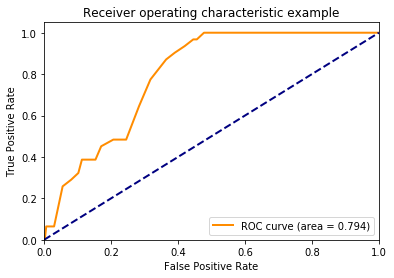

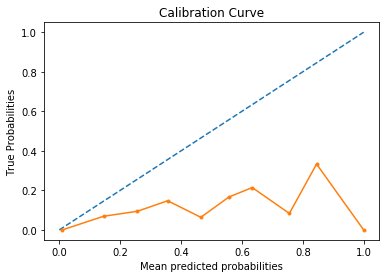

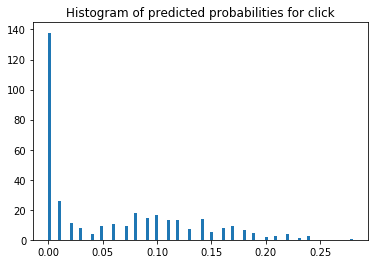

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
knn,0.936,0.064516,0.4,0.794106,-2.210486,0.24,"{""leaf_size"": 30, ""n_neighbors"": 100, ""weights..."


In [38]:
knn_results = evaulate_pipeline(knn_pipeline, X_val, y_val, best_knn_params);
knn_df = pd.DataFrame(knn_results, index= ['knn'])
knn_df

# summary of model metrics

In [40]:

metrics_df = pd.concat([rf_df, knn_df,catboost_df])
metrics_df.sort_values(by='AUC')

if CALC_PARAMS:
    now = datetime.now()
    now_string = now.strftime("%m_%d_%Y__%H_%M")
    metrics_df.reset_index().to_csv(f"configuration_{now_string}.csv", index=False)
metrics_df

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.938,0.032258,0.5,0.816425,-2.141406,0.761634,"{""class_weight"": ""balanced"", ""criterion"": ""gin..."
knn,0.936,0.064516,0.4,0.794106,-2.210486,0.240000,"{""leaf_size"": 30, ""n_neighbors"": 100, ""weights..."
catboost,0.938,0.032258,0.5,0.813536,-2.141406,0.240532,"{""min_data_in_leaf"": 100, ""depth"": 4, ""l2_leaf..."


# Exaplinable AI:  Shap Values

In [41]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


Shap Values (Shapely Additive exPlanations is a model Agnostic method for explaining model predictions
It is based on theory developed by Loid Shapley in the 1950's 

## Shap Summary Plot

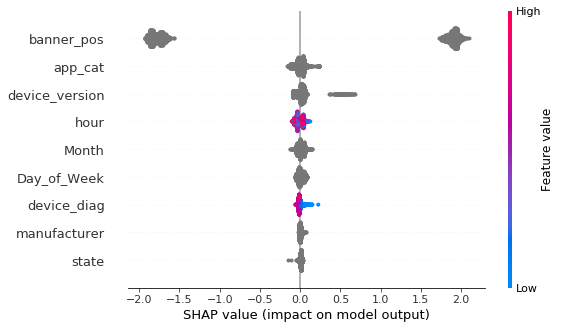

In [42]:

shap.summary_plot(shap_values)

#### explanation
This graph is actually a series of dot-plots:every observation(row) is representated as a dot
for each variable in the model we have a dot-plot showing a dot for each observation in the train set
X-axis: The shap value i.e. the negative or positive contribution of the observation's variable to the final prediction
Y-axis: in case where many observation have the same shap value the dots are stacked vertically
Color: For continuous variables the color represent whether the value of the variable is high or low in the observation

##### Example: TODO verify
in the device_diag variable we see that large screens (strong red) are associated with increased (positive) probability for a click

In [43]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

# 3 random predictions local explanations

In [44]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [45]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [46]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

# Section 8: Prediction on external data set

In [47]:
model = catboost_pipe

In [48]:
testset = pd.read_csv("ctr_dataset_test.csv")

In [49]:
test_df = add_features(testset)

In [50]:
X_test  = test_df[features]


In [51]:
y_hat = model.predict_proba(X_test)

In [52]:
best_threshold_catboost = catboost_df['threshold'].values[0]
best_threshold_catboost

0.2405322875911637

In [53]:
y_pred = (y_hat[:,1] >= best_threshold_catboost).astype(int)
predictions = pd.Series(y_pred)

#### Total predictions , total clicks predicted,  Percentage of predicted clicks:

In [54]:
f"N={predictions.count()}, Clicks={predictions.sum()}, Clicks Percent= {round(predictions.mean()*100,3)}%"

'N=629764, Clicks=3456, Clicks Percent= 0.549%'

# Group 8 output

In [55]:
predictions.to_csv('output_8.txt', index=False)

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
